In [65]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import linregress

In [66]:
yf_data = yf.download('F', start="1800-01-01")
yf_data.reset_index(inplace=True)
yf_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,F,F,F,F,F,F
0,1972-06-01 00:00:00+00:00,0.226079,2.153220,2.173495,2.149165,0.000000,1091238
1,1972-06-02 00:00:00+00:00,0.225653,2.149165,2.173495,2.141055,2.153220,1174468
2,1972-06-05 00:00:00+00:00,0.225653,2.149165,2.169440,2.141055,2.149165,5209582
3,1972-06-06 00:00:00+00:00,0.223099,2.124835,2.157275,2.116725,2.149165,1424158
4,1972-06-07 00:00:00+00:00,0.221821,2.112670,2.137000,2.112670,2.124835,675088


In [67]:
# Daily returns calculations
data = yf_data[["Date", "Adj Close"]]
data.set_index("Date", inplace=True)
data = data.rename(columns={"Adj Close": "Ford stock price"})
data["Daily returns"] = data["Ford stock price"].pct_change()*100
data = data.loc[data["Daily returns"] != 0]

# Volatility calculations
rolling_window = 20
data["Rolling Mean"] = data["Daily returns"].rolling(window=rolling_window).mean()
data["Rolling Variance"] = data["Daily returns"].rolling(window=rolling_window).apply(
    lambda x: ((x - x.mean()) ** 2).sum() / (len(x) - 1), raw=True
)
data["Volatility"] = data["Rolling Variance"] ** 0.5
data.drop(columns=["Rolling Mean", "Rolling Variance"], inplace=True)

# Drop NA rows
data.dropna(axis=0, how="any", inplace=True)

data

Price,Ford stock price,Daily returns,Volatility
Ticker,F,,
Date,,,
1972-07-03 00:00:00+00:00,0.216712,-0.391405,0.665883
1972-07-05 00:00:00+00:00,0.215435,-0.589425,0.671239
1972-07-06 00:00:00+00:00,0.217989,1.185751,0.706344
1972-07-07 00:00:00+00:00,0.217138,-0.390634,0.701274
1972-07-10 00:00:00+00:00,0.214583,-1.176424,0.727097
...,...,...,...
2024-12-09 00:00:00+00:00,10.600000,0.856329,1.747434
2024-12-10 00:00:00+00:00,10.560000,-0.377358,1.743549


Text(0, 0.5, 'Ford stock price')

<Figure size 1200x600 with 0 Axes>

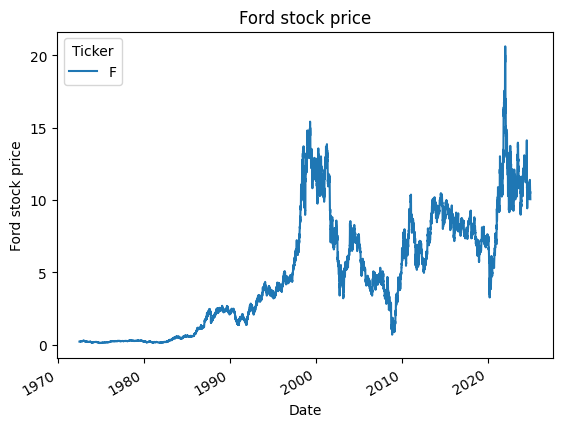

In [68]:
plt.figure(figsize=(12, 6))
data.plot(y='Ford stock price', title='Ford stock price')
plt.xlabel('Date')
plt.ylabel('Ford stock price')

In [69]:
print(f"Mean daily return is {round(data['Daily returns'].mean(), 5)}%")
print(f"Mean volatility over stock returns is {round(data['Volatility'].mean(), 5)}")

print(f"\nAnnualized mean daily return is {round(data['Daily returns'].mean()*252, 5)}%")
print(f"Annualized mean volatility over stock returns is {round(data['Volatility'].mean()*(252**0.5), 5)}")

Mean daily return is 0.05732%
Mean volatility over stock returns is 2.0509

Annualized mean daily return is 14.44448%
Annualized mean volatility over stock returns is 32.55703


In [70]:
## Getting

data['YearMonth'] = data.index.to_period('M')
monthly_variance = data.groupby('YearMonth')['Daily returns'].var()/100
monthly_variance.index = monthly_variance.index.to_timestamp()

# Compute Monthly Stock Price Change (Delta S)
monthly_prices = data.groupby('YearMonth')['Ford stock price'].last()
monthly_price_change = monthly_prices.diff()

# Compute Monthly Variance Change (Delta Variance)
monthly_variance_change = monthly_variance.diff()

# Estimate \rho (Correlation)
correlation_rho = np.corrcoef(monthly_price_change[1:].values.ravel(), monthly_variance_change[1:].values)[0, 1]

variance_lagged = monthly_variance[:-1]
variance_next = monthly_variance[1:]

delta_variance = variance_next.values - variance_lagged.values
slope, intercept, r_value, p_value, std_err = linregress(variance_lagged.values, delta_variance)

# \kappa is the negative of the slope
kappa_reg = -slope

# \theta is the intercept divided by \kappa
if kappa_reg != 0:
    theta_reg = intercept / kappa_reg
else:
    theta_reg = np.nan

print(correlation_rho)
print(kappa_reg)
print(theta_reg)

-0.06971521386189902
0.3084192191794811
0.052744022091343976


C:\Users\nikhi\AppData\Local\Temp\ipykernel_23992\1531354220.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['YearMonth'] = data.index.to_period('M')


TASK 2 -> GBM and Heston Models

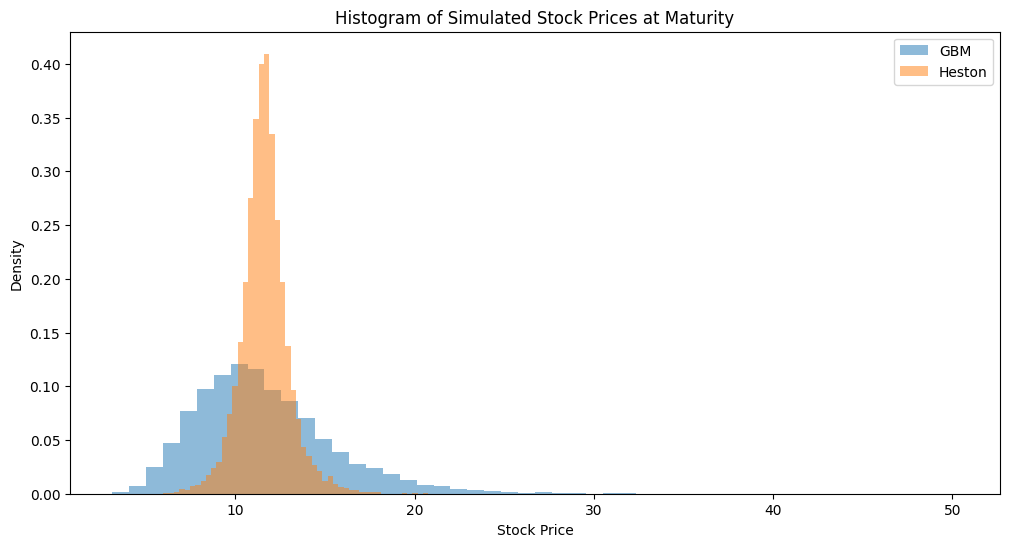

In [71]:
# Parameters
S0 = data["Ford stock price"].iloc[-1] # Initial stock price
S0 = float(S0.iloc[0])
alpha = (data['Daily returns'].mean()*252)/100  # Mean annualized return (drift)
# alpha = 0
sigma = data['Volatility'].mean()*(252**0.5)/100  # Annualized volatility
dt = 1/252  # Time step (1 trading day)
T = 1  # Total time (1 year)
N = int(T / dt)  # Number of time steps (252 days)
simulations = 10000  # Number of simulated paths

# Geometric Brownian Motion Simulation
np.random.seed(42)  # Set seed for reproducibility
random_numbers = np.random.normal(0, 1, (simulations, N))  # Generate standard normal random numbers
dW = random_numbers * np.sqrt(dt)  # Scale random numbers by sqrt(dt) for Brownian motion
W = np.cumsum(dW, axis=1)  # Compute cumulative sum along time axis for Brownian motion
t = np.arange(1, N+1) * dt  # Time points for the simulation
drift = (alpha - 0.5 * sigma**2) * t  # Compute the deterministic drift component of GBM
stock_paths_gbm = S0 * np.exp(sigma * W + drift)  # Compute GBM stock price paths

# Extract stock prices at maturity
stock_prices_gbm = stock_paths_gbm[:, -1]  # Final stock prices for each path at maturity (T)

# Heston Model Parameters
# xi = 0.3  # Volatility of variance
# kappa = 2.0  # Rate of mean reversion
# theta = 0.04  # Long-run variance
# rho = -0.7  # Correlation between stock price and variance
# v0 = sigma**2  # Initial variance, squared GBM volatility

xi = 0.3  # Volatility of variance
kappa = kappa_reg  # Rate of mean reversion
theta = theta_reg  # Long-run variance
rho = correlation_rho  # Correlation between stock price and variance
v0 = sigma**2  # Initial variance, squared GBM volatility

# Heston Model Simulation
v = np.full((simulations, N), v0)  # Initialize variance paths with the initial variance
random_numbers_1 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_S
random_numbers_2 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_V
dW_S = random_numbers_1 * np.sqrt(dt)  # Scale random numbers for stock price Brownian motion
dW_V = rho * random_numbers_1 * np.sqrt(dt) + np.sqrt(1 - rho**2) * random_numbers_2 * np.sqrt(dt)
# Create correlated Brownian motion for variance using rho

# Simulate variance and enforce non-negativity
for i in range(1, N):  # Iterate over time steps
    v[:, i] = v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + xi * np.sqrt(np.maximum(v[:, i-1], 0)) * dW_V[:, i-1]
    # Update variance based on Heston stochastic variance formula
    v[:, i] = np.maximum(v[:, i], 0)  # Ensure variance stays non-negative

# Initialize stock paths
stock_paths_heston = np.zeros((simulations, N))
stock_paths_heston[:, 0] = S0  # Initial stock price

for i in range(1, N):
    stock_paths_heston[:, i] = stock_paths_heston[:, i-1] * np.exp(
        v[:, i-1] * dW_S[:, i-1] - 0.5 * v[:, i-1]**2 * dt + alpha * dt
    )

# Compute Heston stock price paths using stochastic volatility

# Extract stock prices at maturity
stock_prices_heston = stock_paths_heston[:, -1]  # Final stock prices for each path at maturity (T)

# Histograms
bins = 50  # Number of bins for the histogram
plt.figure(figsize=(12, 6))  # Create a figure with specified size

plt.hist(stock_prices_gbm, bins=bins, alpha=0.5, label='GBM', density=True)
# Plot histogram for GBM stock prices
plt.hist(stock_prices_heston, bins=bins, alpha=0.5, label='Heston', density=True)
# Plot histogram for Heston stock prices
plt.title("Histogram of Simulated Stock Prices at Maturity")  # Add a title to the plot
plt.xlabel("Stock Price")  # Label the x-axis
plt.ylabel("Density")  # Label the y-axis
plt.legend()  # Add a legend to distinguish GBM and Heston

Task 3
GBM Z(T)=exp(−α−rσW(T)−12(α−rσ)2T)

Heston model Z(T)=exp(−∫T0α−rv(t)√dW(t)−12∫T0(α−rv(t)√)2dt)

In [72]:
### Compute Z(T) for GBM

r = 0.04598

# Take Brownian motion at the last step
W_T = W[:, -1]

# Insert into the formula
Z_T_GBM = np.exp(-((alpha - r) / sigma) * W_T - 0.5 * ((alpha - r) / sigma)**2 * T)
mean_Z_T_GBM = np.mean(Z_T_GBM)
print(f"Mean of Z(T) for GBM: {mean_Z_T_GBM}")

correlation_Z_T_GBM = np.corrcoef(Z_T_GBM, stock_prices_gbm)[0, 1]
print(f"Correlation between Z(T) and S(T) for GBM: {correlation_Z_T_GBM}")
### Compute Z(T) for the Heston Model
# Compute Z(T) for stochastic volatility model
Z_T_heston = np.exp(-np.cumsum((alpha - r) / np.sqrt(np.maximum(v, 1e-8)) * dW_S, axis=1)[:, -1] - 0.5 * np.cumsum(((alpha - r) / np.sqrt(np.maximum(v, 1e-8)))**2 * dt, axis=1)[:, -1])

mean_Z_T_heston = np.mean(Z_T_heston)
print(f"\nMean of Z(T) for Heston: {mean_Z_T_heston}")

correlation_Z_T_heston = np.corrcoef(Z_T_heston, stock_prices_heston)[0, 1]
print(f"Correlation between Z(T) and S(T) for Heston: {correlation_Z_T_heston}")

### Divide into bins
stock_bins_GBM = np.linspace(stock_prices_gbm.min(), stock_prices_gbm.max(),bins + 1)
stock_bins_heston = np.linspace(stock_prices_heston.min(), stock_prices_heston.max(),bins + 1)


### GBM
bin_indices_GBM = np.digitize(stock_prices_gbm, stock_bins_GBM)
mean_Z_per_bin_GBM = np.array([np.mean(Z_T_GBM[bin_indices_GBM == i])
  if np.sum(bin_indices_GBM == i) > 0 else 0
  for i in range(1, len(stock_bins_GBM))
])
physical_prob_GMB = np.array([np.sum(bin_indices_GBM == i) / simulations for i in range(1, len(stock_bins_GBM))])
risk_neutral_prob_GBM = physical_prob_GMB * mean_Z_per_bin_GBM

### Heston
bin_indices_heston = np.digitize(stock_prices_heston, stock_bins_heston)
mean_Z_per_bin_heston = np.array([np.mean(Z_T_heston[bin_indices_heston == i])
  if np.sum(bin_indices_heston == i) > 0 else 0
  for i in range(1, len(stock_bins_heston))
])
physical_prob_heston = np.array([np.sum(bin_indices_heston == i) / simulations for i in range(1, len(stock_bins_heston))])
risk_neutral_prob_heston = physical_prob_heston * mean_Z_per_bin_heston

### Compute stock price under Risk-Neutral measure
stock_bins_centers_GBM = (stock_bins_GBM[:-1] + stock_bins_GBM[1:]) / 2
stock_bins_centers_heston = (stock_bins_heston[:-1] + stock_bins_heston[1:]) / 2

expected_stock_price_GBM = np.sum(risk_neutral_prob_GBM * stock_bins_centers_GBM);
expected_stock_price_heston = np.sum(risk_neutral_prob_heston * stock_bins_centers_heston);

print(risk_neutral_prob_GBM)
print(risk_neutral_prob_heston)

print(f"\nExpected stock price for GBM {expected_stock_price_GBM}")
print(f"Expected stock price for the Heston model {expected_stock_price_heston}")

print(f"\nExpected stock return for GBM {expected_stock_price_GBM / S0}")
print(f"Expected stock return for the Heston model {expected_stock_price_heston / S0}")

Mean of Z(T) for GBM: 1.0015516495415453
Correlation between Z(T) and S(T) for GBM: -0.9043563512747125

Mean of Z(T) for Heston: 0.9421513179147023
Correlation between Z(T) and S(T) for Heston: -0.40509537182803973
[3.15649458e-03 1.38493684e-02 4.30924009e-02 6.98027441e-02
 1.00679492e-01 1.14251509e-01 1.16978253e-01 1.16699813e-01
 1.03480085e-01 7.97136370e-02 6.68652977e-02 5.07396826e-02
 3.45451840e-02 2.52160614e-02 1.70055184e-02 1.41180812e-02
 1.02532487e-02 6.65659122e-03 4.01275897e-03 3.65375773e-03
 1.96744514e-03 1.41958328e-03 1.18815402e-03 7.51285809e-04
 4.27616295e-04 4.54289176e-04 7.92839222e-05 1.16977746e-04
 3.75648480e-05 1.09659579e-04 1.06875195e-04 3.42955728e-05
 3.41779080e-05 0.00000000e+00 0.00000000e+00 3.11385115e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[3.11049802e-04 3.02